# Preprocesamiento y Análisis Exploratorio de Imágenes MRI de Tumores Cerebrales
En este notebook se realiza la carga, preprocesamiento y análisis exploratorio del dataset de imágenes MRI para clasificación de tumores cerebrales.

## 1. Librerías necesarias

In [20]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import shutil
import cv2

## 2. Configuración de rutas y entorno local

In [ ]:
# Obtener ruta absoluta del proyecto
PROJECT_ROOT = str(Path.cwd().parent)

# Definir rutas
ROOT_DATA_PATH = os.path.join(PROJECT_ROOT, 'data/')
ORIGINAL_PATH = os.path.join(ROOT_DATA_PATH, 'original')
DATASET_PATH = os.path.join(ORIGINAL_PATH, 'brain-cancer-mri-dataset/')
KAGGLE_PATH = str(Path.home() / '.kaggle')

# Paso previo: crear estructura de carpetas si no existe
data_root = os.path.join(PROJECT_ROOT, 'data')
data_original = os.path.join(data_root, 'original')
data_preproc = os.path.join(data_root, 'preprocesadas')
for carpeta in [data_root, data_original, data_prepro
    if not os.path.exists(carpeta):
        os.makedirs(carpeta, exist_ok=True)
        print(f'[INFO] Carpeta creada: {carpeta}')
    else:
        print(f'[INFO] Carpeta ya existe: {carpeta}')

# Descargar desde Kaggle si no existe
if not os.path.exists(DATASET_PATH):
    print(f"Descargando dataset desde Kaggle a: {ORIGINAL_PATH}")
    if not os.path.exists(KAGGLE_PATH):
        os.makedirs(KAGGLE_PATH, exist_ok=True)
    print(f"Coloca tu archivo kaggle.json en: {KAGGLE_PATH}")
    os.makedirs(ORIGINAL_PATH, exist_ok=True)
    kaggle_cmd = (
        f"kaggle datasets download -d orvile/brain-cancer-mri-dataset -p {ORIGINAL_PATH} --unzip"
    )
    print(f"Ejecutando: {kaggle_cmd}")
    os.system(kaggle_cmd)
    print("¡Descarga y extracción completadas!")
else:
    print(f"El dataset ya está disponible en: {DATASET_PATH}")

Descargando dataset desde Kaggle a: d:\Proyectos_programación\mriTumorClassifier\data/original
Coloca tu archivo kaggle.json en: C:\Users\Andres\.kaggle
Ejecutando: kaggle datasets download -d orvile/brain-cancer-mri-dataset -p d:\Proyectos_programación\mriTumorClassifier\data/original --unzip
¡Descarga y extracción completadas!
¡Descarga y extracción completadas!


In [22]:
# --- Reorganizar carpetas de clases a la raíz de 'data/original' ---

# Nombres de las carpetas de clase esperadas
CLASES_OBJETIVO = ['brain_glioma', 'brain_menin', 'brain_tumor']

# Usar la ruta de 'original' como raíz
root_original = os.path.join(ROOT_DATA_PATH, 'original')

# Buscar recursivamente las carpetas de clase
for root, dirs, files in os.walk(root_original):
    for clase in CLASES_OBJETIVO:
        if clase in dirs:
            origen = os.path.join(root, clase)
            destino = os.path.join(root_original, clase)
            if origen != destino:
                print(f"Moviendo {origen} -> {destino}")
                if os.path.exists(destino):
                    print(f"[ADVERTENCIA] Ya existe {destino}, omitiendo...")
                else:
                    shutil.move(origen, destino)

# Eliminar carpetas vacías intermedias (excepto 'original')
def eliminar_vacias(path):
    for dirpath, dirnames, filenames in os.walk(path, topdown=False):
        if dirpath == path:
            continue
        if not dirnames and not filenames:
            print(f"Eliminando carpeta vacía: {dirpath}")
            os.rmdir(dirpath)

eliminar_vacias(root_original)

# Eliminar carpeta 'Brain_Cancer raw MRI data' si existe y está vacía
dataset_raw = os.path.join(root_original, 'Brain_Cancer raw MRI data')
if os.path.exists(dataset_raw):
    try:
        shutil.rmtree(dataset_raw)
        print(f"Carpeta '{dataset_raw}' eliminada.")
    except Exception as e:
        print(f"No se pudo eliminar '{dataset_raw}': {e}")

print("Estructura simplificada. Ahora las carpetas de clase están directamente en 'data/original'.")


Moviendo d:\Proyectos_programación\mriTumorClassifier\data/original\Brain_Cancer raw MRI data\Brain_Cancer\brain_glioma -> d:\Proyectos_programación\mriTumorClassifier\data/original\brain_glioma
[ADVERTENCIA] Ya existe d:\Proyectos_programación\mriTumorClassifier\data/original\brain_glioma, omitiendo...
Moviendo d:\Proyectos_programación\mriTumorClassifier\data/original\Brain_Cancer raw MRI data\Brain_Cancer\brain_menin -> d:\Proyectos_programación\mriTumorClassifier\data/original\brain_menin
[ADVERTENCIA] Ya existe d:\Proyectos_programación\mriTumorClassifier\data/original\brain_menin, omitiendo...
Moviendo d:\Proyectos_programación\mriTumorClassifier\data/original\Brain_Cancer raw MRI data\Brain_Cancer\brain_tumor -> d:\Proyectos_programación\mriTumorClassifier\data/original\brain_tumor
[ADVERTENCIA] Ya existe d:\Proyectos_programación\mriTumorClassifier\data/original\brain_tumor, omitiendo...
Carpeta 'd:\Proyectos_programación\mriTumorClassifier\data/original\Brain_Cancer raw MRI da

## 3. Exploración de la estructura de carpetas y conteo de imágenes

In [23]:
# Verificación de integridad de datos y rutas
from collections import defaultdict

root_data = os.path.join(ROOT_DATA_PATH, 'original')
clases = ['brain_glioma', 'brain_menin', 'brain_tumor']
conteo_imagenes = defaultdict(int)
problemas = []

print('Verificando carpetas y conteo de imágenes por clase:')
for clase in clases:
    ruta_clase = os.path.join(root_data, clase)
    if not os.path.exists(ruta_clase):
        problemas.append(f"[ERROR] No existe la carpeta: {ruta_clase}")
        continue
    imagenes = glob(os.path.join(ruta_clase, '*.jpg'))
    conteo_imagenes[clase] = len(imagenes)
    print(f"  {clase}: {len(imagenes)} imágenes")
    if len(imagenes) == 0:
        problemas.append(f"[ERROR] No se encontraron imágenes en: {ruta_clase}")

if problemas:
    print("\nSe detectaron problemas de integridad:")
    for p in problemas:
        print(p)
    raise RuntimeError("Corrige los problemas de integridad antes de continuar.")
else:
    print("\nIntegridad de datos verificada. Todas las clases tienen imágenes disponibles.")

Verificando carpetas y conteo de imágenes por clase:
  brain_glioma: 2004 imágenes
  brain_menin: 2004 imágenes
  brain_tumor: 2048 imágenes

Integridad de datos verificada. Todas las clases tienen imágenes disponibles.


## 3.1 Verificación de integridad de datos
Antes de procesar, se verifica que existan imágenes en cada carpeta de clase y que las rutas sean correctas. Si alguna clase no tiene imágenes, se detalla el error y se detiene el flujo para evitar resultados vacíos o inconsistentes.

In [24]:
root_data = os.path.join(ROOT_DATA_PATH, 'original')
clases = ['brain_glioma', 'brain_menin', 'brain_tumor']
print("Clases detectadas:", clases)

Clases detectadas: ['brain_glioma', 'brain_menin', 'brain_tumor']


## 4. Visualización de imágenes de ejemplo por clase

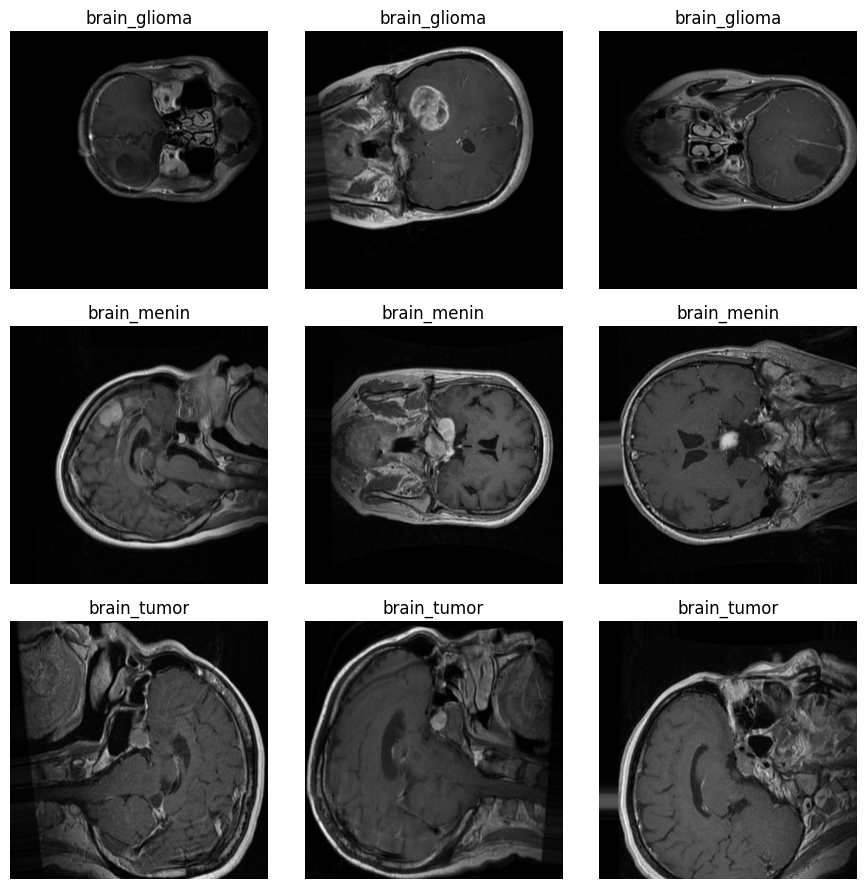

In [25]:
def mostrar_ejemplos_originales(clases, n=3):
    ruta_base = os.path.join(ROOT_DATA_PATH, 'original')
    plt.figure(figsize=(n*3, len(clases)*3))
    for i, clase in enumerate(clases):
        ruta_clase = os.path.join(ruta_base, clase)
        imagenes = glob(os.path.join(ruta_clase, '*.jpg'))
        count = 0
        for img_path in imagenes:
            if count >= n:
                break
            # Cargar imagen original en escala de grises
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                try:
                    with Image.open(img_path) as pil_img:
                        img = np.array(pil_img.convert('L'))
                except Exception as e:
                    print(f"[ADVERTENCIA] No se pudo cargar la imagen: {img_path} ({e})")
                    continue
            plt.subplot(len(clases), n, i*n + count + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'{clase}')
            plt.axis('off')
            count += 1
        if count == 0:
            print(f"[ADVERTENCIA] No se encontraron imágenes válidas para la clase: {clase}")
    plt.tight_layout()
    plt.show()

mostrar_ejemplos_originales(clases, n=3)

## 6. Función de preprocesado y normalización

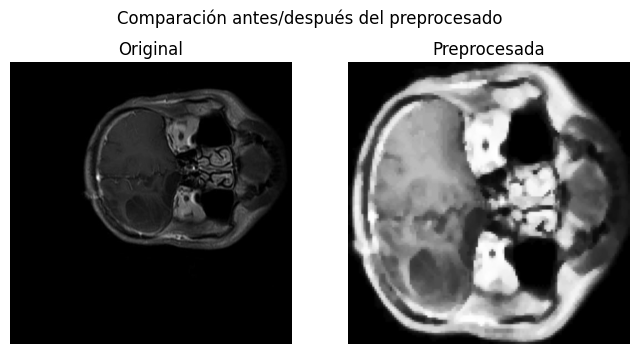

In [ ]:
def preprocesar_imagen(img_path, size=(128,128)):
    # Intentar cargar con OpenCV
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        try:
            with Image.open(img_path) as pil_img:
                pil_img = pil_img.convert('L')
                img = np.array(pil_img)
        except Exception as e:
            print(f"[ERROR] No se pudo cargar la imagen: {img_path} ({e})")
            return np.zeros(size)
    # Recorte automático: eliminar fondo negro (bounding box)
    _, thresh = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        img = img[y:y+h, x:x+w]
    # Redimensionar
    img = cv2.resize(img, size)
    # Filtro de mediana para reducir ruido
    img = cv2.medianBlur(img, 3)
    # Equalización de histograma para mejorar contraste
    img = cv2.equalizeHist(img)
    # Normalización z-score
    mean = img.mean()
    std = img.std() if img.std() > 0 else 1.0
    img = (img - mean) / std
    # Reescalar a [0,1] tras z-score
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# Comparación antes/después del preprocesado
imagenes_clase = glob(os.path.join(root_data, clases[0], '*.jpg'))
if not imagenes_clase:
    print(f'[ADVERTENCIA] No se encontraron imágenes en la clase: {clases[0]}')
else:
    img_path = imagenes_clase[0]
    # Imagen original (sin recorte ni mejoras)
    img_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_orig is None:
        with Image.open(img_path) as pil_img:
            img_orig = np.array(pil_img.convert('L'))
    img_proc = preprocesar_imagen(img_path)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_orig, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img_proc, cmap='gray')
    plt.title('Preprocesada')
    plt.axis('off')
    plt.suptitle('Comparación antes/después del preprocesado')
    plt.show()

In [ ]:
# Guardar imágenes originales y preprocesadas en carpetas separadas

print('PROJECT_ROOT:', PROJECT_ROOT)
print('ROOT_DATA_PATH:', ROOT_DATA_PATH)
print('Carpeta preprocesadas (esperada):', os.path.join(ROOT_DATA_PATH, 'preprocesadas'))

if not os.path.exists(os.path.join(ROOT_DATA_PATH, 'preprocesadas')):
    print('[ADVERTENCIA] La carpeta preprocesadas no existe. Se creará.')
    os.makedirs(os.path.join(ROOT_DATA_PATH, 'preprocesadas'), exist_ok=True)

def depurar_img(img, img_path):
    if img is None:
        print(f'[DEPURACIÓN] img es None para {img_path}')
        return False
    if not isinstance(img, np.ndarray):
        print(f'[DEPURACIÓN] img no es ndarray para {img_path}')
        return False
    print(f'[DEPURACIÓN] img.shape={img.shape}, min={img.min()}, max={img.max()}, sum={img.sum()}, dtype={img.dtype}, únicos={np.unique(img)[:5]}... para {img_path}')
    return True

from PIL import Image as PILImage

total_guardadas = {}
for clase in clases:
    ruta_clase = os.path.join(root_data, clase)
    imgs = glob(os.path.join(ruta_clase, '*.jpg'))
    out_orig = os.path.join(ORIGINAL_PATH, clase)
    out_proc = os.path.join(ROOT_DATA_PATH, 'preprocesadas', clase)
    print(f'Ruta de guardado preprocesadas para {clase}:', out_proc)
    os.makedirs(out_orig, exist_ok=True)
    os.makedirs(out_proc, exist_ok=True)
    print(f'Procesando clase: {clase} ({len(imgs)} imágenes)')
    guardadas = 0
    for i, img_path in enumerate(imgs):
        nombre = os.path.basename(img_path)
        destino_orig = os.path.join(out_orig, nombre)
        if not os.path.exists(destino_orig):
            shutil.copy2(img_path, destino_orig)
        img_proc = preprocesar_imagen(img_path)
        depurar_img(img_proc, img_path)
        if img_proc is not None and img_proc.sum() > 0:
            destino_proc = os.path.join(out_proc, nombre)
            img_uint8 = (img_proc * 255).clip(0,255).astype(np.uint8)
            try:
                PILImage.fromarray(img_uint8).save(destino_proc)
                if os.path.exists(destino_proc):
                    guardadas += 1
                else:
                    print(f'[ERROR] PIL no guardó la imagen: {destino_proc}')
            except Exception as e:
                print(f'[ERROR] PIL falló: {e} para {destino_proc}')
        else:
            print(f'[ADVERTENCIA] Imagen no procesada o vacía: {img_path}')
        if (i+1) % 100 == 0 or (i+1) == len(imgs):
            print(f'  {i+1}/{len(imgs)} imágenes procesadas')
    total_guardadas[clase] = guardadas
    print(f'  Total preprocesadas y guardadas para {clase}: {guardadas}')
print('Imágenes originales y preprocesadas guardadas en sus respectivas carpetas.')
print('Resumen por clase:', total_guardadas)

PROJECT_ROOT: d:\Proyectos_programación\mriTumorClassifier
ROOT_DATA_PATH: d:\Proyectos_programación\mriTumorClassifier\data/
Carpeta preprocesadas (esperada): d:\Proyectos_programación\mriTumorClassifier\data/preprocesadas
Ruta de guardado preprocesadas para brain_glioma: d:\Proyectos_programación\mriTumorClassifier\data/preprocesadas\brain_glioma
Procesando clase: brain_glioma (2004 imágenes)
[DEPURACIÓN] img.shape=(128, 128), min=0.0, max=0.9999999967101083, sum=6521.894096190734, dtype=float64, únicos=[0.         0.02745098 0.04313725 0.05490196 0.0627451 ]... para d:\Proyectos_programación\mriTumorClassifier\data/original\brain_glioma\brain_glioma_0001.jpg
[ERROR] OpenCV no guardó la imagen, intento con PIL: d:\Proyectos_programación\mriTumorClassifier\data/preprocesadas\brain_glioma\brain_glioma_0001.jpg
[OK] PIL guardó la imagen: d:\Proyectos_programación\mriTumorClassifier\data/preprocesadas\brain_glioma\brain_glioma_0001.jpg
[DEPURACIÓN] img.shape=(128, 128), min=0.0, max=0.99

## 7. Preparación de arrays de datos y etiquetas

In [35]:
# Usar datos preprocesados si existen, si no usar originales
ruta_preproc = os.path.join(ROOT_DATA_PATH, 'preprocesadas')
if os.path.exists(ruta_preproc):
    print('Usando imágenes preprocesadas.')
    data_path = ruta_preproc
else:
    print('Usando imágenes originales.')
    data_path = root_data

X = []
y = []
clase_a_idx = {c: i for i, c in enumerate(clases)}
n_imagenes = 200  # Cambia este valor según recursos disponibles
for clase in clases:
    ruta_clase = os.path.join(data_path, clase)
    imagenes = glob(os.path.join(ruta_clase, '*.jpg'))[:n_imagenes]
    for img_path in imagenes:
        img = preprocesar_imagen(img_path)
        X.append(img)
        y.append(clase_a_idx[clase])
X = np.array(X)
y = np.array(y)
print('Shape X:', X.shape)
print('Shape y:', y.shape)

Usando imágenes preprocesadas.
Shape X: (600, 128, 128)
Shape y: (600,)
Shape X: (600, 128, 128)
Shape y: (600,)


## 8. Visualización de la distribución de clases

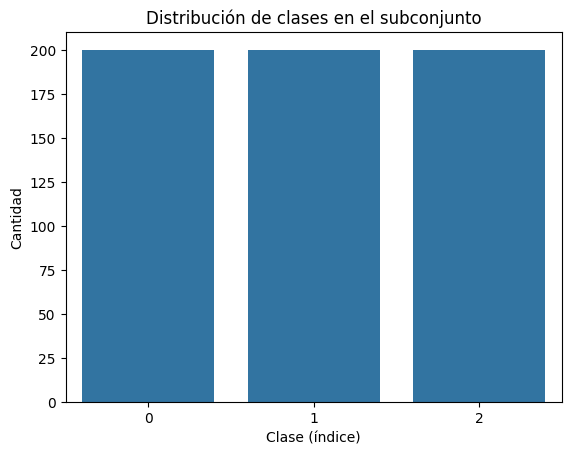

In [36]:
sns.countplot(x=y)
plt.title('Distribución de clases en el subconjunto')
plt.xlabel('Clase (índice)')
plt.ylabel('Cantidad')
plt.show()

---

Con esto, el preprocesamiento y análisis exploratorio están listos para alimentar el modelo de clasificación.